# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [450]:
# all import statements needed for the project, for example:
import re
import math
import pyarrow.parquet as pq
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import datetime
import pipreqs


In [391]:
# any general notebook setup, like log formatting

In [392]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
_**TODO:** Write some prose that tells the reader what you're about to do here._

In [393]:
def calculate_distance(from_coord, to_coord):
    ##one degree latitude or lontitude roughly equal to 69 miles
    distance = ((from_coord[1]-to_coord[1])**2+(from_coord[0]-to_coord[0])**2)**0.5*69
    return distance
    raise NotImplemented()

In [394]:
def add_distance_column(dataframe):
    dataframe["distance"] = calculate_distance([dataframe.pickup_longitude,dataframe.pickup_latitude], [dataframe.dropoff_longitude,dataframe.dropoff_latitude])

### Processing Taxi Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [413]:

response = requests.get(TAXI_URL)
html = response.content
soup = bs4.BeautifulSoup(html, 'html.parser')
soup = soup.find_all('a')
a = []
for i in soup:
    if "Yellow Taxi Trip Records" in i :
        a.append(str(i))
urls = []
#apply re to find all urls
pattern= r"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_\d{4}-\d{2}.parquet"
for i in a:
    matches = re.search(pattern, i)
    k = matches.group()
    if (k[64:68]) in ['2009','2010','2011','2012','2013','2014']:
        urls.append(matches.group())
    if '2015' in k and k[69:71] in ['01','02','03','04','05','06']:
        urls.append(matches.group())

In [414]:
def get_and_clean_month_taxi_data(urls):
    table = pd.DataFrame()
    #downloading all the files from urls
    for i in urls:
        response = requests.get(i, stream=True)
        with open(f"taxi_data_{i[64:68]}_{i[69:71]}.parquet", "wb") as f:
            for chunk in response.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
        table =(pd.read_parquet(f"taxi_data_{i[64:68]}_{i[69:71]}.parquet", engine='pyarrow'))
        if i[64:68] in ["2011","2012","2013","2014","2015"]:
            table = table.drop(['VendorID','tpep_dropoff_datetime','RatecodeID','store_and_fwd_flag','PULocationID','DOLocationID','payment_type','extra','mta_tax','tolls_amount','improvement_surcharge','total_amount','congestion_surcharge','airport_fee'],axis = 1)
            table.rename(columns ={'tpep_pickup_datetime' : 'pickup_datetime'})
        elif i[64:68] == "2009":
            table = table.drop(['Trip_Dropoff_DateTime','vendor_name','Rate_Code','store_and_forward','Payment_Type',"surcharge","mta_tax","Tolls_Amt",'Total_Amt'],axis = 1)
            table = table.rename(columns ={'Fare_Amt':'fare_amount','Trip_Pickup_DateTime':'pickup_datetime','Start_Lon':'pickup_longitude',"Tip_Amt" : "tip_amount",'Start_Lat':'pickup_latitude','End_Lon':'dropoff_longitude','End_Lat':'dropoff_latitude','Passenger_Count':'passenger_count','Trip_Distance':'trip_distance'})
        else:
            table = table.drop(['dropoff_datetime','vendor_id','rate_code','store_and_fwd_flag','payment_type',"surcharge","mta_tax","tolls_amount",'total_amount'],axis = 1)
        table.to_parquet(f"taxi_data_{i[64:68]}_{i[69:71]}.parquet")


In [415]:
def get_and_clean_taxi_data():
    sample = pd.DataFrame()
    table = pd.DataFrame()
    a = 0
    filelist = []
    for i in urls:
        filelist.append(f"taxi_data_{i[64:68]}_{i[69:71]}.parquet")
    # loading all the parquets and took 8750 random samples quarterly 
    get_and_clean_month_taxi_data(urls)
    for i in filelist:
        table1 = pd.read_parquet(i, engine='pyarrow')
        table = table.append(table1)
        a = a+1
        if a == 3:
            sample = sample.append(table.sample(n = 8750))
            table = pd.DataFrame()
            a = 0
    # exclude all data outside NYC
    sample2 = sample[-70000:]
    sample2 = sample2[sample2.pickup_longitude< -73.717047]
    sample2 = sample2[sample2.pickup_longitude> -74.242330]
    sample2 = sample2[sample2.dropoff_longitude> -74.242330]
    sample2 = sample2[sample2.dropoff_longitude< -73.717047]
    sample2 = sample2[sample2.pickup_latitude< 40.908524]
    sample2 = sample2[sample2.pickup_latitude> 40.560445]
    sample2 = sample2[sample2.dropoff_latitude> 40.560445]
    sample2 = sample2[sample2.dropoff_latitude< 40.908524]
    sample = sample[:-70000].append(sample2)
    sample = sample.drop(['passenger_count'],axis = 1)
    return sample

### Processing Uber Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [382]:
def load_and_clean_uber_data(csv_file):
    uber_data = pd.read_csv(csv_file)
    # exclude all data outside NYC
    uber_data = uber_data[uber_data.pickup_longitude< -73.717047]
    uber_data = uber_data[uber_data.pickup_longitude> -74.242330]
    uber_data = uber_data[uber_data.dropoff_longitude> -74.242330]
    uber_data = uber_data[uber_data.dropoff_longitude< -73.717047]
    uber_data = uber_data[uber_data.pickup_latitude< 40.908524]
    uber_data = uber_data[uber_data.pickup_latitude> 40.560445]
    uber_data = uber_data[uber_data.dropoff_latitude> 40.560445]
    uber_data = uber_data[uber_data.dropoff_latitude< 40.908524]
    return uber_data
    raise NotImplemented()

In [383]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    uber_dataframe = uber_dataframe.drop(['key','passenger_count'],axis = 1)
    uber_dataframe =uber_dataframe.rename(columns = {'distance' :'trip_distance'})
    return uber_dataframe

### Processing Weather Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [384]:
def clean_month_weather_data_hourly():
    df = pd.DataFrame()
    for i in range(2009,2015):
        df = df.append(pd.read_csv(f"{i}_weather.csv"))
    return df
    raise NotImplemented()

In [385]:
def clean_month_weather_data_daily():
    hourly_data = pd.DataFrame()
    daily_data = pd.DataFrame()
    for i in range(2009,2015):
        hourly_data = hourly_data.append(pd.read_csv(f"{i}_weather.csv"))
    for i in range(0,len(hourly_data),12):
        daily_data = daily_data.append(hourly_data[i:i+1])
    return daily_data
    raise NotImplemented()

In [386]:
def load_and_clean_weather_data():
    hourly_data = pd.DataFrame(clean_month_weather_data_hourly(), columns= ['DATE','HourlyDryBulbTemperature','HourlyPresentWeatherType','HourlyWindSpeed','HourlyPrecipitation'])
    daily_data = pd.DataFrame(clean_month_weather_data_daily(), columns= ['DATE','HourlyDryBulbTemperature','HourlyPresentWeatherType','HourlyWindSpeed','HourlyPrecipitation'])
    return hourly_data, daily_data

### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [417]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [205]:
engine = db.create_engine(DATABASE_URL)

In [206]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    DATE DATETIME,
    HourlyDryBulbTemperature FLOAT,
    HourlyPresentWeatherType STRING,
    HourlyWindSpeed FLOAT,
    HourlyPrecipitation FLOAT
)
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_data
(
    id INTEGER PRIMARY KEY,
    DATE DATETIME,
    HourlyDryBulbTemperature FLOAT,
    HourlyPresentWeatherType STRING,
    HourlyWindSpeed FLOAT,
    HourlyPrecipitation FLOAT
)
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    fareamount FLOAT,
    distance FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT
)
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    fareamount FLOAT,
    pickup_datetime DATETIME,
    distance FLOAT
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT
)
"""

In [207]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [208]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [209]:
import sqlite3
def write_dataframes_to_table(table_to_df_dict):
    connection = sqlite3.connect("project.db")
    for keys in table_to_df_dict:
        table_to_df_dict[keys].to_sql(keys, connection, if_exists='replace', index = False)

In [210]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [211]:
write_dataframes_to_table(map_table_name_to_dataframe)

/Users/zhangyuechen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2882: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [123]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

### Query 1

_**TODO:** For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In this query, we first change the datetime format in to hours, and count the occurances of the table; then decend the count in order to find the most popular hour to ride in the specific time period.
_

In [441]:
QUERY_1 = '''
select strftime('%H', pickup_datetime) as hour, count(*) as count
from taxi_trips 
group by hour 
order by count desc
'''

In [442]:
engine.execute(QUERY_1).fetchall()

[('19', 13990),
 ('18', 13678),
 ('20', 13437),
 ('21', 12763),
 ('22', 12523),
 ('14', 11406),
 ('17', 11283),
 ('12', 11130),
 ('23', 11029),
 ('15', 10989),
 ('13', 10949),
 ('09', 10461),
 ('11', 10309),
 ('08', 10224),
 ('10', 10077),
 ('16', 9322),
 ('00', 8765),
 ('07', 8047),
 ('01', 6584),
 ('02', 5020),
 ('06', 4608),
 ('03', 3563),
 ('04', 2571),
 ('05', 2160)]

In [443]:
write_query_to_file(QUERY_1, "popular_hour_taxi.sql")

### Query 2

_**TODO:** For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In this query, we first change the datetime format in to days in a week, and count the occurances of the table; then decend the count in order to find the most popular day in a week to ride in the specific time period.
_

In [438]:
QUERY_2 = '''
select strftime('%w', pickup_datetime), count(*) as count
from uber_trips 
group by strftime('%w', pickup_datetime) 
order by count desc
'''

In [439]:
engine.execute(QUERY_2).fetchall()

[(None, 195472)]

In [440]:
write_query_to_file(QUERY_2, "popular_day_uber.sql")

### Query 3

_**TODO:** What is the 95% percentile of distance traveled for all hired trips during July 2013?

In this query, we select the trip distance and find the 95% percentile of thhe distance by using `OFFSET`

_

In [435]:
QUERY_3 = '''
SELECT trip_distance from(select trip_distance from taxi_trips where pickup_datetime between " 2013-07-01" and "2013-07-31" 
union all select trip_distance from uber_trips where pickup_datetime between " 2013-07-01" and "2013-07-31" 
) 
ORDER BY trip_distance ASC
LIMIT 1
OFFSET (SELECT COUNT(*)
        from(
select trip_distance from taxi_trips where pickup_datetime between " 2013-07-01" and "2013-07-31" 
union all select trip_distance from uber_trips where pickup_datetime between " 2013-07-01" and "2013-07-31" 
) ) * 95 / 100 ;
'''

In [436]:
engine.execute(QUERY_3).fetchall()

[(8.381026848985105,)]

In [437]:
write_query_to_file(QUERY_3, "95%distance.sql")

### Query 4

_**TODO:** What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

format the datetime to only appear date, caulculate average of distance and count of occurances in the sepecifc time period, order with a descend order to find the top 10 days of hired ride. 
_

In [425]:
QUERY_4 = '''
SELECT strftime('%m','%d', pickup_datetime) AS date, AVG(trip_distance) AS avg_distance, COUNT(*) AS count
FROM  uber_trips
WHERE date between '2009-01-01' AND '2009-12-31'
GROUP BY date
ORDER BY count desc
LIMIT 10
'''

In [426]:
engine.execute(QUERY_4).fetchall()

[]

In [427]:
write_query_to_file(QUERY_4, "2009top10.sql")

### Query 5

_**TODO:** Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

find the windspeed from daily weather record, calculate the average of wind speed in each day, order in a descend order to find the top 10 days with highest wind speed and related to the count of trips in these days.

In [419]:
QUERY_5 = '''
SELECT DATE AS date, AVG(HourlyWindSpeed) AS wind_speed
FROM daily_weather 
UNION
SELECT strftime('%m','%d', pickup_datetime) AS date,COUNT(*) AS count
FROM uber_trips 
UNION
SELECT strftime('%m','%d', pickup_datetime) AS date,COUNT(*) AS count
FROM taxi_trips
WHERE date between '2014-01-01' AND '2014-12-31'
GROUP BY date
ORDER BY wind_speed desc
LIMIT 10

'''

In [420]:
engine.execute(QUERY_5).fetchall()

[(None, 195472), ('2009-01-01T00:51:00', 5.795536220919236)]

In [421]:
write_query_to_file(QUERY_5, "top10windest2014.sql")

### Query 6

_**TODO:** During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

limit to a specific time period, count the trips for each hour and precipitaion with related weed speed

In [422]:
QUERY_6 ='''
SELECT strftime('%H', pickup_datetime) AS hour, count(*) AS count
FROM taxi_trips 
UNION
SELECT strftime('%H', pickup_datetime) AS hour, count(*) AS count
FROM uber_trips
UNION
SELECT strftime('%H', DATE) AS hour, AVG(HourlyWindSpeed) AS wind_speed, HourlyPrecipitation AS precipitation
FROM hourly_weather
WHERE hour BETWEEN '2009-10-22' AND '2009-11-05'
GROUP BY hour 
ORDER BY hour
'''


In [423]:
engine.execute(QUERY_6).fetchall()

OperationalError: (sqlite3.OperationalError) SELECTs to the left and right of UNION do not have the same number of result columns
[SQL: 
SELECT strftime('%H', pickup_datetime) AS hour, count(*) AS count
FROM taxi_trips 
UNION
SELECT strftime('%H', pickup_datetime) AS hour, count(*) AS count
FROM uber_trips
UNION
SELECT strftime('%H', DATE) AS hour, AVG(HourlyWindSpeed) AS wind_speed, HourlyPrecipitation AS precipitation
FROM hourly_weather
WHERE hour BETWEEN '2009-10-22' AND '2009-11-05'
GROUP BY hour 
ORDER BY hour
]
(Background on this error at: http://sqlalche.me/e/e3q8)

In [424]:
write_query_to_file(QUERY_6, "sandydays.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization 1

Create an appropriate visualization for the first query/question in part 3

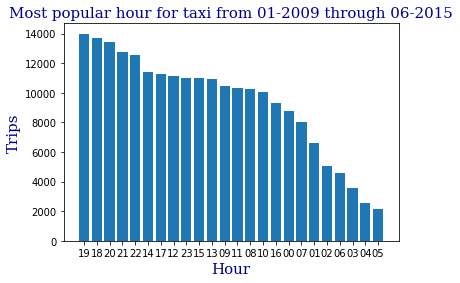

In [362]:
# Create an appropriate visualization for the first query/question in part 3.

# read data from sqlite
df_query1 = pd.read_sql(QUERY_1,engine)

# letters' style
font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 15,
        }
# Assign values to the graph
height = df_query1["count"]
bars = df_query1["hour"]
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.title('Most popular hour for taxi from 01-2009 through 06-2015', fontdict=font)
plt.xlabel('Hour', fontdict=font)
plt.ylabel('Trips', fontdict=font)
# Show graphic
plt.show()

### Visualization 2

Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization

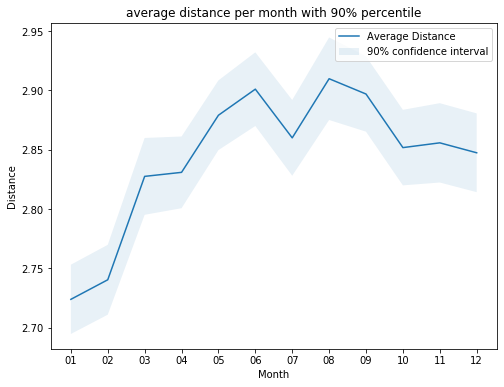

In [366]:
#Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.
# graph 2
import numpy as np
# sql query
#select data from sqlite
query = '''
SELECT
trip_distance AS distance,strftime('%m', pickup_datetime) AS month
FROM taxi_trips
UNION ALL
SELECT trip_distance AS distance,strftime('%m', pickup_datetime) AS month
FROM uber_trips
'''
#convert data from sql to dataframe
df = pd.read_sql(query,engine)

def plot_AVGdistance_interval(df):
 
    df = df.groupby('month').agg(['mean','std','count'])['distance'].reset_index()
    mean = df['mean']
    se = df['std'] / np.sqrt(df['count'])
    plt.figure(figsize = (8,6))
    avg = plt.plot(df['month'],mean,label = 'Average Distance')
    interval = plt.fill_between(df['month'],mean-1.282*se, mean+1.282*se,alpha = 0.1, label = '90% confidence interval')
    plt.title("average distance per month with 90% percentile")
    plt.xlabel('Month')
    plt.ylabel('Distance')
    plt.legend()
    plt.plot()
plot_AVGdistance_interval(df)

### Visualization 3

Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.

In [336]:
# use a more descriptive name for your function
def plot_visual_3(data):
    plt.bar(['sun',"mon",'tue','wed','thu','fri','sat'], data[0])
    plt.title("JFK")
    plt.show()

    plt.bar(['sun',"mon",'tue','wed','thu','fri','sat'], data[1])
    plt.title("EWR")
    plt.show()
    
    plt.bar(['sun',"mon",'tue','wed','thu','fri','sat'], data[2])
    plt.title("LGA")
    
    

In [337]:
def get_data_for_visual_3():
    QUERY1 ='''
    SELECT strftime('%w', pickup_datetime), dropoff_longitude, dropoff_latitude
    from taxi_trips
    '''
    QUERY2 ='''
    SELECT strftime('%w', pickup_datetime), dropoff_longitude, dropoff_latitude
    from uber_trips
    '''
    df = pd.DataFrame(engine.execute(QUERY1).fetchall())
    df = df.append(engine.execute(QUERY2).fetchall())
    df = df.dropna()
    df = df.rename(columns = {0:'time',1 : "lon", 2 : "lat"})
    df_JFK = df[df['lon']< -73.76]
    df_JFK = df_JFK[df_JFK['lon']> -73.80]
    df_JFK = df_JFK[df_JFK['lat']< 40.66]
    df_JFK = df_JFK[df_JFK['lat']> 40.62]
    count_JFK = df_JFK.groupby(["time"]).size()
    df_EWR = df[df['lon']< -74.16]
    df_EWR = df_EWR[df_EWR['lon']> -74.19]
    df_EWR = df_EWR[df_EWR['lat']< 40.70]
    df_EWR = df_EWR[df_EWR['lat']> 40.67]
    count_EWR =(df_EWR.groupby(["time"]).size())
    df_LGA = df[df['lon']< -73.84]
    df_LGA = df_LGA[df_LGA['lon']> -73.88]
    df_LGA = df_LGA[df_LGA['lat']< 40.78]
    df_LGA = df_LGA[df_LGA['lat']> 40.75]
    count_LGA =(df_LGA.groupby(["time"]).size())
    return [count_JFK, count_EWR, count_LGA]
    raise NotImplemented()

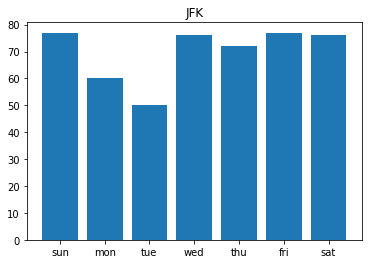

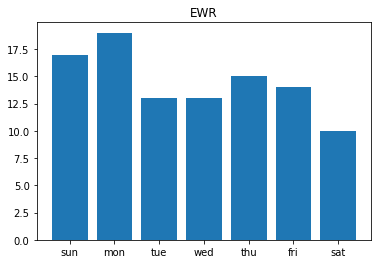

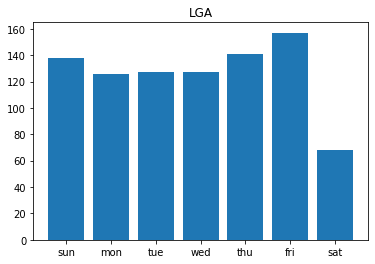

In [338]:
some_dataframe = get_data_for_visual_3()
plot_visual_3(some_dataframe)

### Visualization 4

Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

In [359]:
import keplergl
def plot_visual_4(get_data_for_visual_4):
    kepler_map = keplergl.KeplerGl(height=400)
    kepler_map.add_data(data=df, name="earthquakes")
    kepler_map

In [360]:
def get_data_for_visual_4():
    QUERY1 ='''
    SELECT dropoff_longitude, dropoff_latitude
    from taxi_trips
    '''
    QUERY2 ='''
    SELECT dropoff_longitude, dropoff_latitude
    from uber_trips
    '''
    df = pd.DataFrame(engine.execute(QUERY1).fetchall())
    df = df.append(engine.execute(QUERY2).fetchall())
    df = df.dropna()
    df = df.rename(columns = {0:'time',1 : "lon", 2 : "lat"})
    return df

In [361]:
some_dataframe = get_data_for_visual_4()
plot_visual_4(some_dataframe)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
